# Compare CellCommander annotations associated with publication objects
**Author**: Adam Klie (last modified: 10/08/2023)<br>
***
**Description**: This script looks at whether the samples as processed by me look like those processed from the publication

# Set-up

In [1]:
# Imports
import os
import seaborn as sns
import anndata as ad
import glob
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib_venn import venn2

In [2]:
# List h5ads to integrate
results_paths = ["/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_scRNA-seq/annotation/26Oct23/cellcommander"]

In [17]:
# List h5ads to integrate
h5ad_paths = []
for results_path in results_paths:
    h5ad_paths += sorted(glob.glob(os.path.join(results_path, "*", "reduce_dimensions", "*.h5ad")))
len(h5ad_paths), h5ad_paths

(5,
 ['/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_scRNA-seq/annotation/26Oct23/cellcommander/H1-D11/reduce_dimensions/scanpy_default_pca.h5ad',
  '/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_scRNA-seq/annotation/26Oct23/cellcommander/H1-D14/reduce_dimensions/scanpy_default_pca.h5ad',
  '/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_scRNA-seq/annotation/26Oct23/cellcommander/H1-D21/reduce_dimensions/scanpy_default_pca.h5ad',
  '/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_scRNA-seq/annotation/26Oct23/cellcommander/H1-D32/reduce_dimensions/scanpy_default_pca.h5ad',
  '/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_scRNA-seq/annotation/26Oct23/cellcommander/H1-D39/reduce_dimensions/scanpy_default_pca.h5ad'])

# Concatenate all the samples

In [4]:
# Read in samples
adata_list = []
samples = []
for h5ad_path in h5ad_paths:
    sample = h5ad_path.split("/")[-3].split("-")[1]
    adata = sc.read_h5ad(h5ad_path)
    adata.obs.index = sample + "_" + adata.obs.index
    adata_cp = sc.AnnData(adata.layers["counts"].copy(), obs=adata.obs.copy(), var=adata.var.copy())
    adata_list.append(adata_cp)
    samples.append(sample)
samples

['D14', 'D11', 'D21', 'D39', 'D32']

In [5]:
# Concat samples
adata_concat = ad.concat(adata_list, label="sample", keys=samples)
adata_concat.obs["sample"].value_counts()

/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/anndata/_core/merge.py:217: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(dtype):


sample
D11    8788
D14    7386
D21    2443
D32    2260
D39    2221
Name: count, dtype: int64

# Create annotations for previous
For now, I'm manually labeling the clusters using the UMAP in the publication.

In [6]:
# Load in previous adata
adata_prev = sc.read_h5ad("/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_scRNA-seq/annotation/24Oct23/GSE202497_final_cluster.h5ad")
adata_prev

AnnData object with n_obs × n_vars = 25686 × 2520
    obs: 'percent_mito', 'n_counts', 'log10_n_counts', 'log_n_counts', 'n_genes', 'log10_n_genes', 'batch', 'donor', 'norm_log_counts', 'log10_usable_counts', 'log_usable_counts', 'leiden'
    var: 'mean-0', 'std-0', 'mean-1', 'std-1', 'mean-2', 'std-2', 'mean-3', 'std-3', 'mean-4', 'std-4', 'mean', 'std'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [1]:
# Create a venn diagram of the barcode overlap
venn2([set(adata_concat.obs.index), set(adata_prev.obs_names)], set_labels=["New pipeline barcodes", "Publication barcodes"])
plt.show()


KeyboardInterrupt



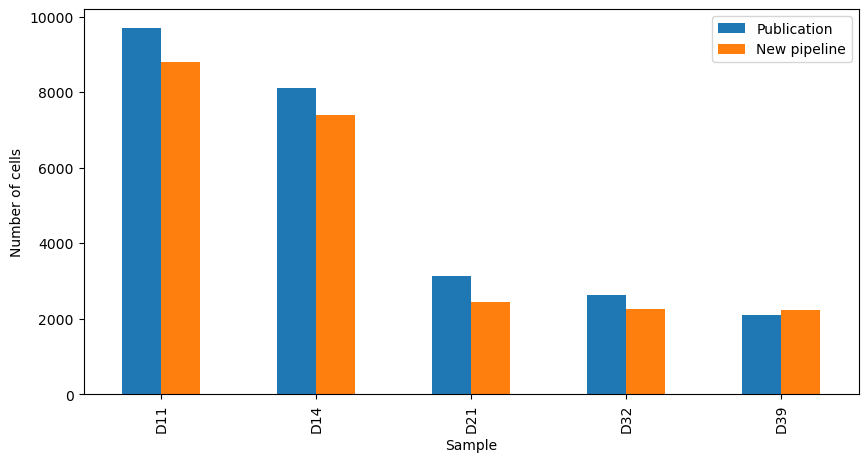

In [11]:
# Compare the numbers of each sample in the new pipeline vs the publication using one barplot
fig, ax = plt.subplots(figsize=(10, 5))
prev_counts = adata_prev.obs["donor"].value_counts()
new_counts = adata_concat.obs["sample"].value_counts()
plot_data = pd.DataFrame({"Publication": prev_counts, "New pipeline": new_counts}).fillna(0)
plot_data.plot.bar(ax=ax)
ax.set_ylabel("Number of cells")
ax.set_xlabel("Sample")
plt.show()

In [12]:
# Manually define clusters
cellid_dict = {
    "0": "ENP1",
    "1": "PP1",
    "2": "SC.alpha",
    "3": "ENP2",
    "4": "ENP.alpha",
    "5": "ENP3",
    "6": "PP1",
    "7": "SC.beta",
    "8": "PP2",
    "9": "ENP1",
    "10": "SC.EC",
    "11": "SC.EC",
    "12": "SC.delta",
}

In [13]:
# Add the cellid column
adata_prev.obs["cellid"] = adata_prev.obs["leiden"].map(cellid_dict)

/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/minicon

[<Axes: title={'center': 'leiden'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'cellid'}, xlabel='UMAP1', ylabel='UMAP2'>]

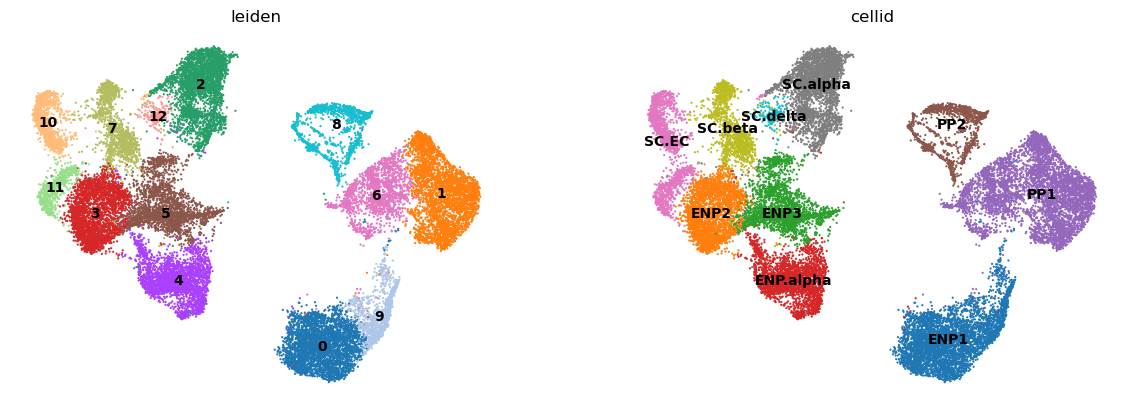

In [14]:
# Plot the umap
sc.pl.umap(adata_prev, color=["leiden", "cellid"], frameon=False, s=10, show=False, legend_loc="on data")

# See if the clusters I've identified match up

In [19]:
# Variables 
cellid_map = adata_prev.obs["cellid"]
outdir_path = "/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_scRNA-seq/annotation/26Oct23/cellcommander"

In [21]:
# Read in samples
adata_list = []
samples = []
for h5ad_path in h5ad_paths:

    # Read in the sample and use the previous cellid map
    print(f"Reading in {h5ad_path}")
    sample = h5ad_path.split("/")[-3]
    day = sample.split("-")[1]
    adata = sc.read_h5ad(h5ad_path)
    adata.obs.index = day + "_" + adata.obs.index
    adata.obsm["X_umap"] = adata.obsm["X_scanpy_default_umap"].copy()
    adata.obs["cellid"] = adata.obs.index.map(cellid_map).astype("category")
    adata.obs["initial_leiden_1"] = adata.obs["initial_leiden_1"].astype("category")

    # Drop all cells with cellids that that are NaN or have less than 10 cells
    na_mask = adata.obs["cellid"].isna()
    num_nas = na_mask.sum()
    print(f"Number of cells with NaN cellids: {num_nas}")
    adata = adata[~na_mask, :]
    cellid_counts = adata.obs["cellid"].value_counts()
    low_cellids = cellid_counts[cellid_counts < 10].index
    low_cellid_mask = adata.obs["cellid"].isin(low_cellids)
    num_low_cellids = low_cellid_mask.sum()
    print(f"Number of cells with low cellids: {num_low_cellids}")
    adata = adata[~low_cellid_mask, :]

    # Make a dir to save
    curr_outdir_path = os.path.join(outdir_path, sample, "annotate", "publication")
    if not os.path.exists(curr_outdir_path):
        os.makedirs(curr_outdir_path)

    # Plot the UMAP for that sample
    print("Plotting UMAP")
    adata.obs.index = adata.obs.index.str.replace(day + "_", "")
    with plt.rc_context({"axes.facecolor": "white", "figure.facecolor": "white"}):
        sc.pl.umap(adata, color=["initial_leiden_1", "cellid"], frameon=False, show=False)
        plt.savefig(os.path.join(curr_outdir_path, "publication_mapped_cellid_umap.png"), dpi=300, bbox_inches="tight")
        plt.close()
    
    # Save
    print("Saving")
    adata.write(os.path.join(curr_outdir_path, "annotated.h5ad"))

Reading in /cellar/users/aklie/data/datasets/Zhu2023_sc-islet_scRNA-seq/annotation/26Oct23/cellcommander/H1-D11/reduce_dimensions/scanpy_default_pca.h5ad
Number of cells with NaN cellids: 605
Number of cells with low cellids: 15
Plotting UMAP


/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/

Saving
Reading in /cellar/users/aklie/data/datasets/Zhu2023_sc-islet_scRNA-seq/annotation/26Oct23/cellcommander/H1-D14/reduce_dimensions/scanpy_default_pca.h5ad
Number of cells with NaN cellids: 373
Number of cells with low cellids: 14
Plotting UMAP


/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/

Saving
Reading in /cellar/users/aklie/data/datasets/Zhu2023_sc-islet_scRNA-seq/annotation/26Oct23/cellcommander/H1-D21/reduce_dimensions/scanpy_default_pca.h5ad
Number of cells with NaN cellids: 253
Number of cells with low cellids: 4
Plotting UMAP


/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/

Saving
Reading in /cellar/users/aklie/data/datasets/Zhu2023_sc-islet_scRNA-seq/annotation/26Oct23/cellcommander/H1-D32/reduce_dimensions/scanpy_default_pca.h5ad
Number of cells with NaN cellids: 435
Number of cells with low cellids: 5
Plotting UMAP


/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/

Saving
Reading in /cellar/users/aklie/data/datasets/Zhu2023_sc-islet_scRNA-seq/annotation/26Oct23/cellcommander/H1-D39/reduce_dimensions/scanpy_default_pca.h5ad
Number of cells with NaN cellids: 500
Number of cells with low cellids: 7
Plotting UMAP


/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/

Saving


# DONE!

---